Dữ liệu ban đầu:
         Timestamp  MTO_13-FI-11415.PV  MTO_13-PIC-12105.PV  \
0  6/11/2022 12:00         65901.75781              0.14921   
1  6/11/2022 12:10         66234.44531              0.14884   
2  6/11/2022 12:20         66225.75781              0.14762   
3  6/11/2022 12:30         65884.88281              0.14784   
4  6/11/2022 12:40         66787.54688              0.14714   

   MTO_13-TI-12103.PV  MTO_13-FI-12101.PV  MTO_13-FI-12101-H.PV  \
0            29.30403         67581.94531               2.06562   
1            29.33455         68212.92969               2.11083   
2            29.36505         67270.43750               2.07104   
3            29.35537         66948.46875               2.04801   
4            29.33456         67765.24219               2.09888   

   MTO_13-FI-12102.PV  MTO_13-FI-12102-H.PV  MTO_13-FI-12112.PV  \
0         77759.72656               1.20945         65943.66406   
1         78432.14062               1.23610         66087.30469   


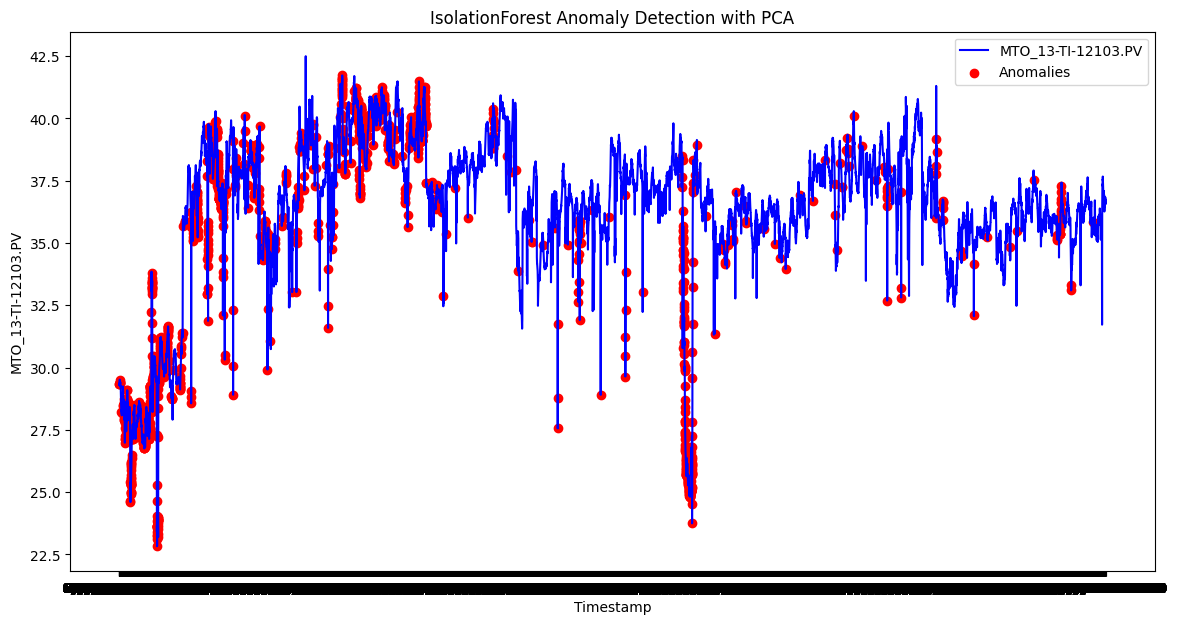

In [3]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Đọc file CSV
file_path = "../../../data/Compressor_2022_June-Oct.csv"
pandas_df = pd.read_csv(file_path)

# Hiển thị dữ liệu
print("Dữ liệu ban đầu:")
print(pandas_df.head())

# Lấy danh sách header và bỏ qua cột đầu tiên
columns = pandas_df.columns

# Chọn cột đầu tiên làm trục X (Timestamp) và một cột được chọn làm trục Y
timestamp_column = columns[0]
selected_column = columns[3]  # Thay thế bằng tên cột bạn muốn chọn làm trục Y

# Hàm xử lý dữ liệu thiếu
def handle_missing_data(df, method="mean_fill"):
    if method == "backward_fill":
        df = df.fillna(method='bfill')
    elif method == "forward_fill":
        df = df.fillna(method='ffill')
    elif method == "mean_fill":
        df = df.fillna(df.mean())
    # Nếu là "no-cleaning", không làm gì cả
    return df


# Áp dụng phương pháp xử lý mean fill
pandas_df.iloc[:, 1:] = handle_missing_data(pandas_df.iloc[:, 1:], "mean_fill")

# Hiển thị dữ liệu sau khi xử lý
print("Dữ liệu sau khi xử lý mean fill:")
print(pandas_df.head())

# Chọn các cột cần thiết cho mô hình IsolationForest (bỏ qua cột đầu tiên)
features = pandas_df[columns[1:]].values

# Áp dụng PCA để giảm số lượng đặc trưng
pca = PCA(n_components=2)  # Thay đổi số lượng thành phần chính nếu cần
features_pca = pca.fit_transform(features)

# Sử dụng IsolationForest để phát hiện bất thường
model = IsolationForest(contamination=0.1)  # Đặt mức độ bất thường mong muốn
model.fit(features_pca)

# Dự đoán các điểm bất thường
predictions = model.predict(features_pca)

# Thêm cột dự đoán vào DataFrame
pandas_df["anomaly"] = predictions

# Vẽ biểu đồ line với trục X là Timestamp và trục Y là selected_column, các điểm bất thường được đánh dấu bằng scatter màu đỏ
plt.figure(figsize=(14, 7))

# Vẽ biểu đồ line cho cột được chọn
plt.plot(pandas_df[timestamp_column], pandas_df[selected_column], label=selected_column, color='blue')

# Vẽ các điểm bất thường bằng scatter màu đỏ
anomalies = pandas_df[pandas_df["anomaly"] == -1]
plt.scatter(anomalies[timestamp_column], anomalies[selected_column], color='red', label="Anomalies")

plt.xlabel(timestamp_column)
plt.ylabel(selected_column)
plt.legend()
plt.title("IsolationForest Anomaly Detection with PCA")
plt.show()
